## Check SFINCS output

In [1]:
import os
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#import plotly.graph_objects as go
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

from hydromt_sfincs import SfincsModel, utils

### Load SFINCS results

In [2]:
runname = 'sfincs_sofala_test_with_spw2'
dirrun = os.path.join('..','computations',runname)

In [3]:
# # Specify name of the historical SFINCS output file
# ncfile = os.path.join(dirrun,"sfincs_his.nc")
# ds_sfincs = xr.open_dataset(ncfile); del ncfile

# # Rename the stations coordinate to station_id and convert type to integer
# ds_sfincs["station_id"] = ds_sfincs["station_id"].astype(int)

# # Load SFINCS mapfile
# ncfile = os.path.join(dirrun,"sfincs_map.nc")
# ds_sfincs_map = xr.open_dataset(ncfile); del ncfile

In [4]:
mod = SfincsModel(dirrun, mode="r")

In [5]:
mod.read_results()
list(mod.results.keys())

['inp',
 'msk',
 'qinf',
 'zb',
 'zs',
 'zsmax',
 'wind_u',
 'wind_v',
 'surface_air_pressure',
 'precipitation_rate',
 'total_runtime',
 'average_dt',
 'status',
 'point_zb',
 'point_zs',
 'point_qinf',
 'point_wind_speed',
 'point_wind_direction',
 'point_patm',
 'point_prcp']

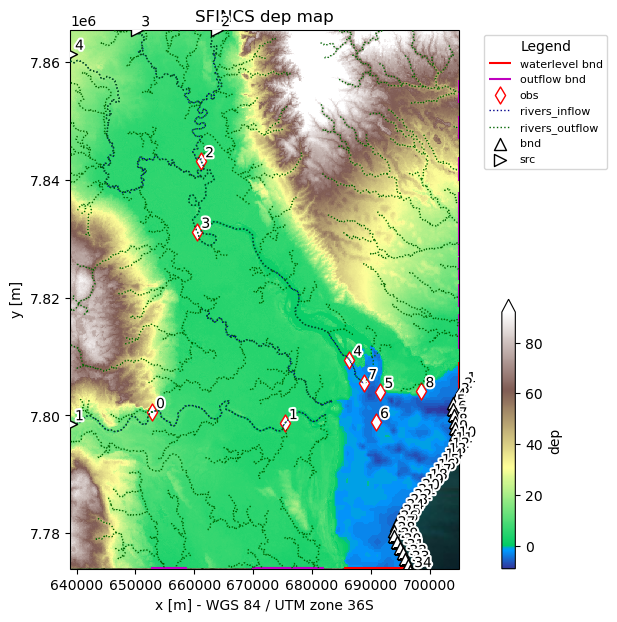

In [6]:
# plot the model layout
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", plot_geoms=True, figsize=(11, 7))

(<Figure size 600x900 with 3 Axes>,
 array([<Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <Axes: title={'center': 'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>,
        <Axes: title={'center': 'SFINCS precipitation forcing (precip_2d)'}, ylabel='mean precipitation\n[mm.hr-1]'>],
       dtype=object))

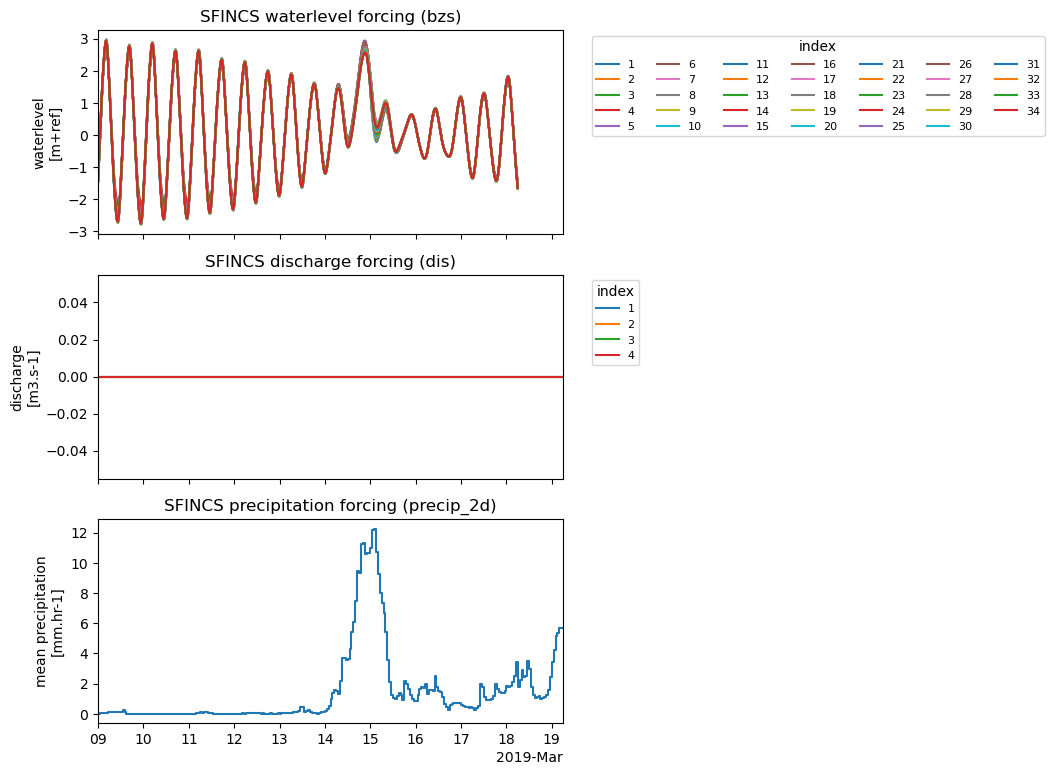

In [7]:
mod.plot_forcing()

### Plot maximum depth

In [8]:
# first we are going to select our subgrid resolution depth dataset
depfile = os.path.join(dirrun, "subgrid", "dep_subgrid.tif")
da_dep = mod.data_catalog.get_rasterdataset(depfile)

In [9]:
da_zsmax = mod.results["zsmax"].max(dim="timemax")
hmin = 0.05

In [10]:
#downscale the floodmap
da_hmax = utils.downscale_floodmap(
    zsmax=da_zsmax,
    dep=da_dep,
    hmin=hmin,
    #gdf_mask=gdf_osm,
    floodmap_fn=os.path.join(dirrun, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
)

Text(0.5, 1.0, 'SFINCS maximum water depth')

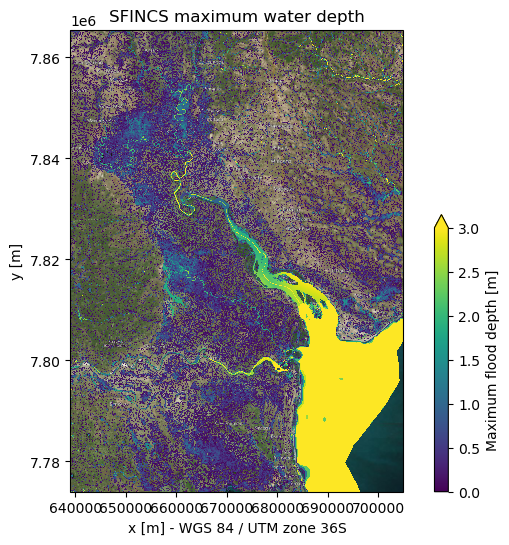

In [11]:
# create a basemap plot with hmax on top
fig, ax = mod.plot_basemap(
    fn_out=None,
    figsize=(8, 6),
    variable=da_hmax,
    plot_bounds=False,
    plot_geoms=False,
    bmap="sat",
    zoomlevel=11,
    vmin=0,
    vmax=3.0,
    cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
)
ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

### Plot observations

In [12]:
ncfile = os.path.join(dirrun,"sfincs_his.nc")
ds_his = xr.open_dataset(ncfile)

In [13]:
ds_his
ds_his["station_id"] = ds_his["station_id"].astype(int)

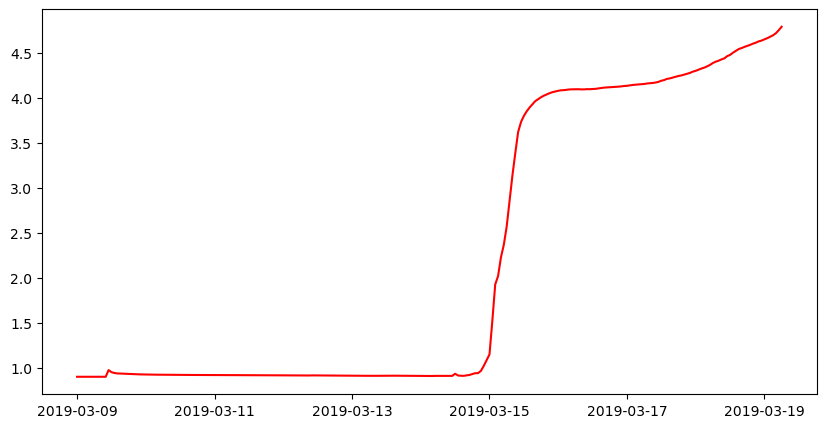

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ds_his.time,ds_his['point_zs'].where(ds_his.station_id==4,drop=True),color='r',label=f'')

### Check forcing

In [15]:
# Load SFINCS mapfile
ncfile = os.path.join(dirrun,"sfincs_map.nc")
ds_sfincs_map = xr.open_dataset(ncfile); del ncfile

In [16]:
ds_sfincs_map

<xarray.Dataset> Size: 3GB
Dimensions:               (n: 914, m: 659, corner_n: 915, corner_m: 660,
                           time: 247, timemax: 11, runtime: 1)
Coordinates:
    x                     (n, m) float32 2MB ...
    y                     (n, m) float32 2MB ...
  * time                  (time) datetime64[ns] 2kB 2019-03-09 ... 2019-03-19...
  * timemax               (timemax) datetime64[ns] 88B 2019-03-10 ... 2019-03...
Dimensions without coordinates: n, m, corner_n, corner_m, runtime
Data variables: (12/17)
    inp                   int32 4B ...
    corner_x              (corner_n, corner_m) float32 2MB ...
    corner_y              (corner_n, corner_m) float32 2MB ...
    crs                   int32 4B ...
    sfincsgrid            int32 4B ...
    msk                   (n, m) float32 2MB ...
    ...                    ...
    wind_v                (time, n, m) float32 595MB ...
    surface_air_pressure  (time, n, m) float32 595MB ...
    precipitation_rate    (time, n, m) float32 595MB ...
    total_runtime         (runtime) float32 4B ...
    average_dt            (runtime) float32 4B ...
    status                (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.9.2 of Mar 14 2023 15:42:34 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.1.1-Dollerup
    Build-Date:                          $Date: 2024-08-28
    title:                               SFINCS map netcdf output

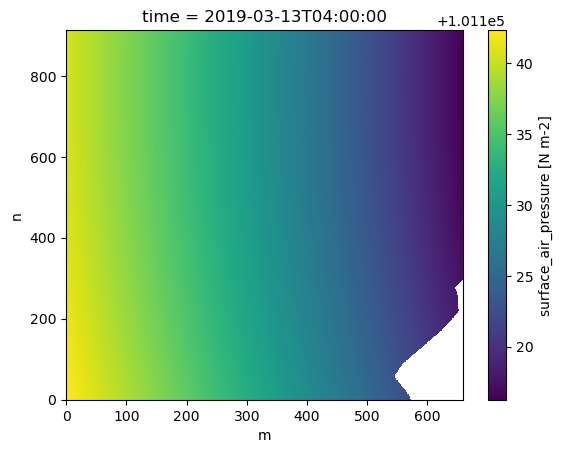

In [19]:
ds_sfincs_map['surface_air_pressure'].isel(time=100).plot()